In [1]:
import h5py
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K
import time
#import joblib

# compute a mask per event, and attach vec(0) for the first MLP output for those masked
# so S and pho steps are unchanged, but skipping first MLP computations
# the total dim N * D is still the same after the first MLP (those zero constituents are skipping phi)
# --> for zero-padded constituents, directly make D-dim zeros for them after the first MLP
# make a route:
# if mask == 0:
#     pass to first MLP
# else:
#     make D-dim zeros

with h5py.File('data.h5', 'r') as f:
    x = f['x'][:, :32*2, :]
    y = f['y'][:]
    
x[x[:, :, 0] < 2] = 0

q5 = np.percentile(x[:, :, 0], 5)
q95 = np.percentile(x[:, :, 0], 95)
x[:, :, 0] = (x[:, :, 0] - 0) / (q95 - q5)

train_ratio = 0.5
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size = test_ratio, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
del X_train_val, Y_train_val

X_train shape: (439999, 64, 3)
X_val   shape: (88001, 64, 3)
X_test  shape: (352000, 64, 3)
Y_train shape: (439999, 5)
Y_val   shape: (88001, 5)
Y_test  shape: (352000, 5)


In [2]:
def build_phi():
    input_constituent = layers.Input(shape=(3,))  # Each constituent has 3 features
    x = layers.Dense(64, activation='relu', use_bias=False)(input_constituent)
    x = layers.Dense(64, activation='relu', use_bias=False)(x)
    x = layers.Dense(64, activation='relu', use_bias=False)(x)
    return models.Model(input_constituent, x, name="phi")

def build_rho():
    input_agg = layers.Input(shape=(64,))  # Aggregated max across constituents
    x = layers.Dense(64, activation='relu')(input_agg)
    output = layers.Dense(5, activation='softmax')(x)
    return models.Model(input_agg, output, name="rho")

input_all_constituents = layers.Input(shape=(32*2, 3))
phi = build_phi()
phi_outputs = layers.TimeDistributed(phi)(input_all_constituents)

agg = layers.GlobalMaxPooling1D()(phi_outputs)

rho = build_rho()
final_output = rho(agg)

model = models.Model(input_all_constituents, final_output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 64, 64)         │         8,384 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rho (Functional)                │ (None, 5)              │         4,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,869 (50.27 KB)

 Trainable params: 12,869 (50.27 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    epochs=10, batch_size=128)

Epoch 1/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5314 - loss: 1.1290 - val_accuracy: 0.6459 - val_loss: 0.9300
Epoch 2/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.6481 - loss: 0.9204 - val_accuracy: 0.6557 - val_loss: 0.9113
Epoch 3/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.6654 - loss: 0.8902 - val_accuracy: 0.6750 - val_loss: 0.8728
Epoch 4/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.6726 - loss: 0.8744 - val_accuracy: 0.6753 - val_loss: 0.8705
Epoch 5/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.6792 - loss: 0.8630 - val_accuracy: 0.6890 - val_loss: 0.8456
Epoch 6/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.6828 - loss: 0.8519 - val_accuracy: 0.6899 - val_loss: 0.8524
Epoch 7/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.6833 - loss: 0.8498 - val_accuracy: 0.6843 - val_loss: 0.8453
Epoch 8/10
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.6857 - loss: 0

Text(0, 0.5, 'Loss')

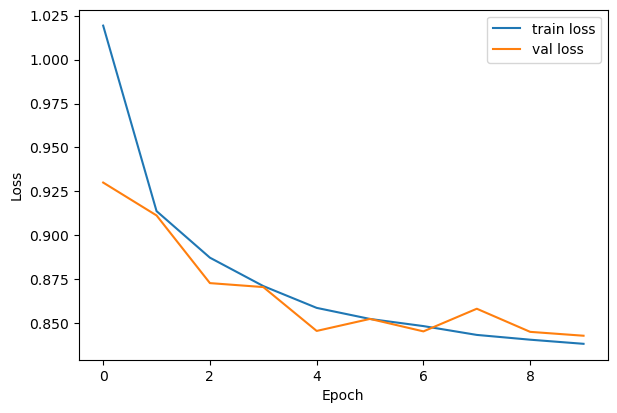

In [4]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [5]:
Y_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

11000/11000 ━━━━━━━━━━━━━━━━━━━━ 10s 925us/step
Accuracy: 0.685846590909091


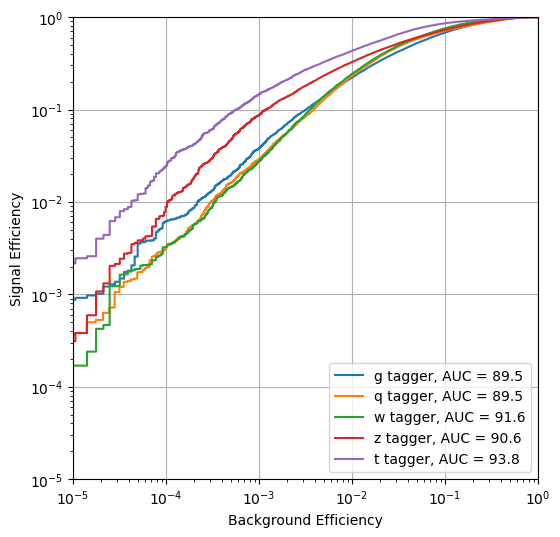

In [13]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    plt.semilogy()
    plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    plt.ylim(0.00001, 1)
    plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best')  
    
plt.figure(figsize=(6, 6))
plot_roc(Y_test, Y_pred, ['g','q','w','z','t'])

In [ ]:
X_test_mask = np.all(X_test == 0, axis = -1)
X_test_nomask = np.zeros(shape=X_test_mask.shape).astype(bool)

In [ ]:
def masked_inference(model, x, mask):
    phi_layer = model.get_layer('time_distributed').layer

    for i in range(
    
    phi_outputs = tf.where(
        mask == False,
        layers.TimeDistributed(phi_layer)(x),
        tf.zeros_like(layers.TimeDistributed(phi_layer)(x))
    )
    return phi_outputs

In [ ]:
start_time = time.time()

phi_outputs_nomask = masked_inference(model, X_test, X_test_nomask)
#agg = model.layers[2](phi_outputs_nomask)
#Y_pred_nomask = model.layers[3](agg)

end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")

In [ ]:
start_time = time.time()

phi_outputs_mask = masked_inference(model, X_test, X_test_mask)
#agg = model.layers[2](phi_outputs_mask)
#Y_pred_mask = model.layers[3](agg)

end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")

In [ ]:
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_mask, axis=1))))

In [ ]:
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_nomask, axis=1))))

In [ ]:
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_mask, axis=1))))